In [1]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [3]:
np.random.seed(42)

# 下载数据
ticker = '^NSEI'
df = yf.download(ticker, start='2024-01-01', end='2025-01-01')

# 数据预处理：Prophet需要两列 [ds, y]
df_prophet = df.reset_index()[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
training_data_len = int(np.ceil(0.8 * len(df_prophet)))
train_data = df_prophet.iloc[:training_data_len]
test_data = df_prophet.iloc[training_data_len:]

In [7]:
model = Prophet(
    yearly_seasonality=True,    # 年季节性
    weekly_seasonality=True,    # 周季节性
    daily_seasonality=False,    # 日季节性（股票无日数据）
    changepoint_prior_scale=0.05  # 控制趋势灵活性
)
model.add_country_holidays(country_name='IN')  # 添加印度节假日
model.fit(train_data)

/opt/anaconda3/lib/python3.12/site-packages/holidays/countries/india.py:176: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)
10:33:32 - cmdstanpy - INFO - Chain [1] start processing
10:33:32 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# 生成未来预测（包括测试集和未来20天）
future = model.make_future_dataframe(periods=len(test_data) + 20, freq='B')  # B=工作日
forecast = model.predict(future)

# 提取测试集预测结果
test_forecast = forecast.iloc[-len(test_data)-20:-20]
test_forecast['y'] = test_data['y'].values  # 关联实际值

# 提取未来20天预测
future_forecast = forecast.iloc[-20:]

/var/folders/b9/966lwbmx12gd_1zc07v_3kvr0000gn/T/ipykernel_47171/2946969218.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_forecast['y'] = test_data['y'].values  # 关联实际值


In [11]:
mape = np.mean(np.abs((test_forecast['y'] - test_forecast['yhat']) / test_forecast['y'])) * 100
mae = mean_absolute_error(test_forecast['y'], test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test_forecast['y'], test_forecast['yhat']))

print(f"Test Set Metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Test Set Metrics:
MAPE: 15.07%
MAE: 3622.37
RMSE: 4625.89


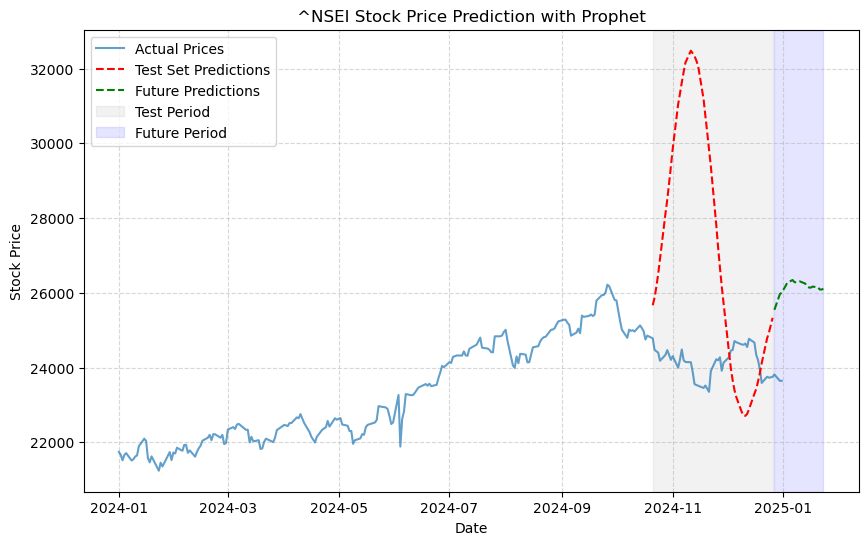

In [13]:
# 提取预测结果
test_forecast = forecast.iloc[training_data_len:-20]  # 测试集预测部分
future_forecast = forecast.iloc[-20:]                 # 未来20天预测

# 创建画布
plt.figure(figsize=(10,6))

# 绘制实际价格（全部历史数据）
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual Prices', alpha=0.7)

# 绘制测试集预测（红色）
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Set Predictions', color='red', linestyle='--')

# 绘制未来预测（绿色）
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Future Predictions', color='green', linestyle='--')

# 标注区域
plt.axvspan(test_forecast['ds'].iloc[0], test_forecast['ds'].iloc[-1], color='gray', alpha=0.1, label='Test Period')
plt.axvspan(future_forecast['ds'].iloc[0], future_forecast['ds'].iloc[-1], color='blue', alpha=0.1, label='Future Period')

# 图表装饰
plt.title(f'{ticker} Stock Price Prediction with Prophet')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [15]:
# 保存未来预测结果
future_forecast[['ds', 'yhat']].to_csv('prophet_forecast.csv', index=False)